# Exploration Notebook for Louvain (UCI-ID 50, Image Segmentation)

## Imports

In [16]:

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sb
import umap.plot
from community import community_louvain
from ucimlrepo import fetch_ucirepo

d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, erro

In [3]:
import sys

sys.path.append("../")
import visualization
import processing
from embedding_obj import EmbeddingObj

## Data Preparation

In [4]:
# fetch dataset (available at https://archive.ics.uci.edu/dataset/50/image+segmentation)
image_segmentation = fetch_ucirepo(id=50)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets)

target_feature = "saturation-mean"
labels = pd.Categorical(y["class"]).codes

X.head()

,region-centroid-col,region-centroid-row,region-pixel-count,short-line-density-5,short-line-density-2,vedge-mean,vedge-sd,hedge-mean,hedge-sd,intensity-mean,rawred-mean,rawblue-mean,rawgreen-mean,exred-mean,exblue-mean,exgreen-mean,value-mean,saturation-mean,hue-mean
0,140.0,125.0,9.0,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333333,7.666667,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,188.0,133.0,9.0,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666667,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,105.0,139.0,9.0,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333333,3.333333,-7.666667,7.555555,0.532628,-0.965946
3,34.0,137.0,9.0,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,39.0,111.0,9.0,0.0,0.0,0.722222,0.374074,0.888889,0.429630,6.037037,7.000000,7.666667,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_14116\1951439884.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


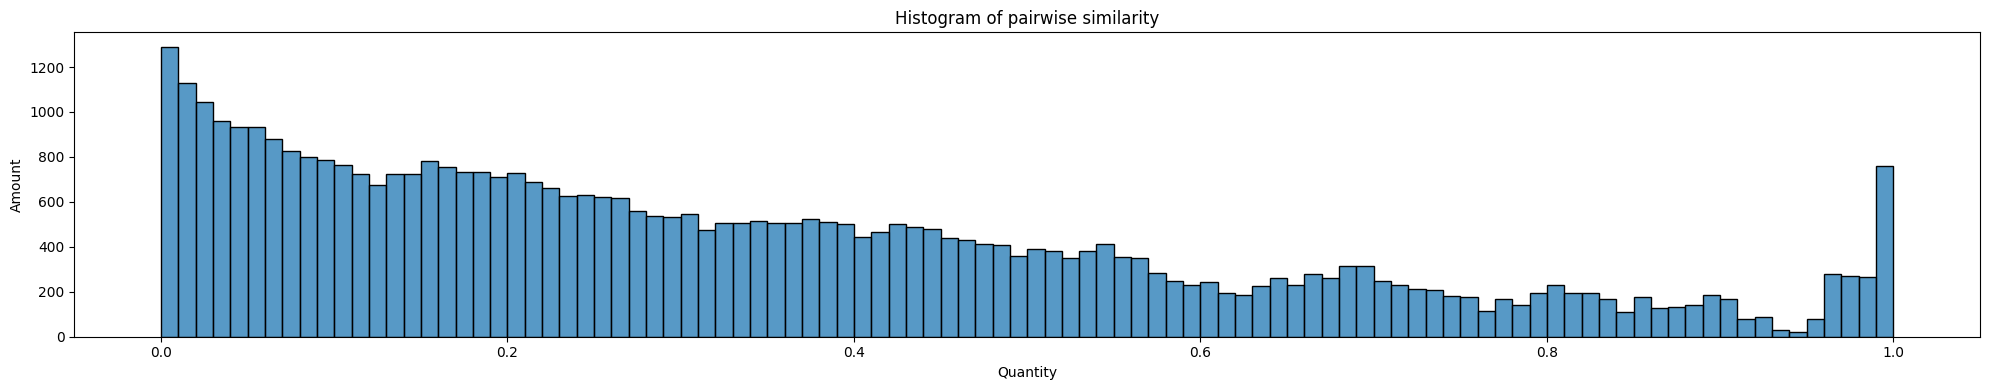

In [5]:
connectivity_pairwise = processing.compute_pairwise_dist(X, [target_feature])

fig, ax = plt.subplots(figsize=(20, 4))
sb.histplot(connectivity_pairwise.flatten(), bins=100, ax=ax)
ax.set_title("Histogram of pairwise similarity")
ax.set_xlabel("Quantity")
ax.set_ylabel("Amount")

fig.tight_layout()
fig.show()

## Compute initial UMAP-Embedding & Louvain Partition

In [6]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]

graph_knn_feat, edge_weights_knn_feat = processing.compute_graph_weights(X, [
    target_feature], n_neighbors=5)

knn_list = [
    EmbeddingObj(graph=graph_umap_knn,
                 embedding={i: coords for i, coords in enumerate(umap_embedding)},
                 edge_weights=edge_weights_umap_knn,
                 title="UMAP-Positions with UMAP-kNN"),
    EmbeddingObj(graph=graph_knn_feat,
                 embedding={i: coords for i, coords in enumerate(umap_embedding)},
                 edge_weights=edge_weights_knn_feat,
                 title=f"UMAP-Positions with kNN for Similarity of '{target_feature}'")
]

for embedding_obj in knn_list:
    embedding_obj.com_partition = community_louvain.best_partition(
        embedding_obj.sim_graph, random_state=0)

    embedding_obj.labels = embedding_obj.com_partition

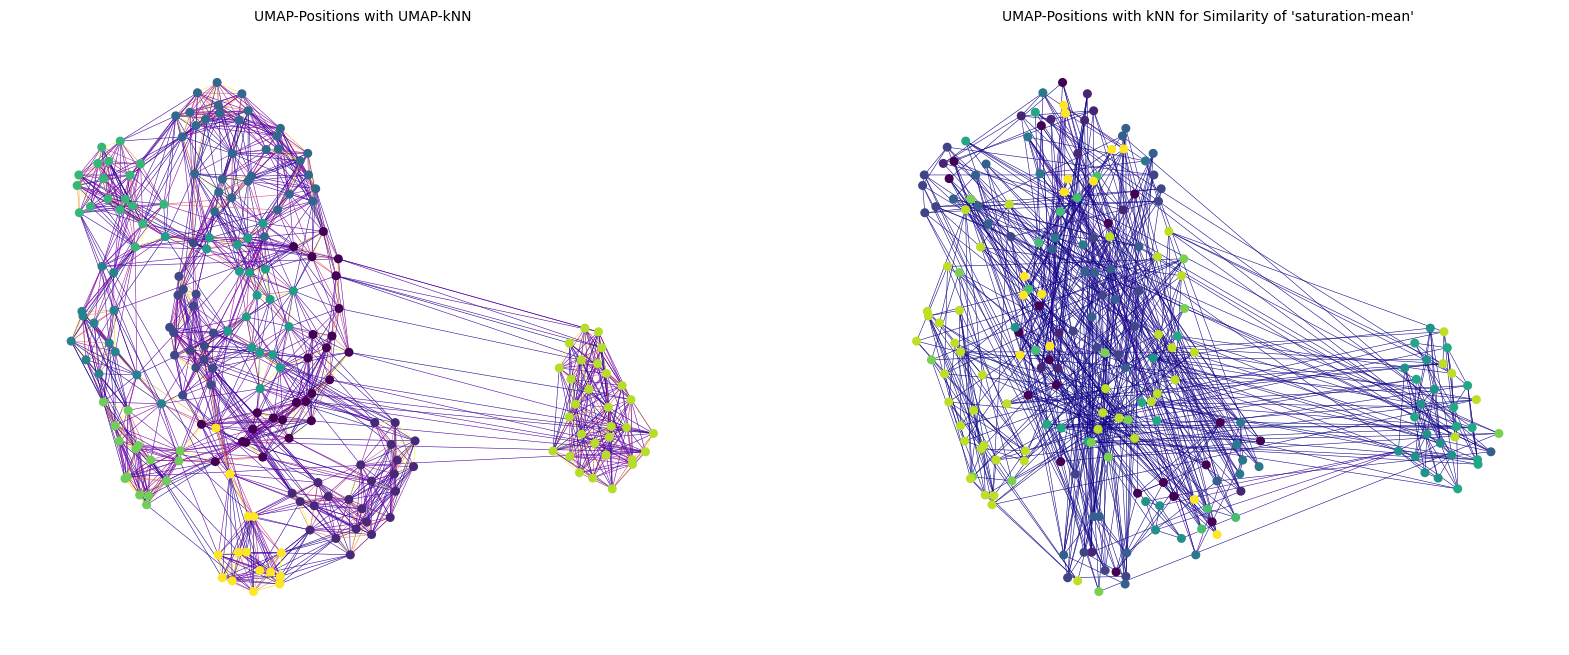

In [25]:
visualization.display_graphs(knn_list,
                             figsize_columns=2,
                             figsize=(20, 8),
                             cmap='viridis',
                             show_cbar=False)

In [26]:
connectivity_umap_knn_nx = nx.Graph(connectivity_umap_knn)

for u, v in connectivity_umap_knn_nx.edges():
    connectivity_umap_knn_nx[u][v]["weight"] = connectivity_pairwise[u][v]

## Visualize embeddings

### 2.1 No MST, no threshold

In [35]:
embeddings, partition_dict = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    [1, 20, 50, 100])

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


In [36]:
# partition_values = embeddings[0].labels
partition_values = set(partition_dict.values())

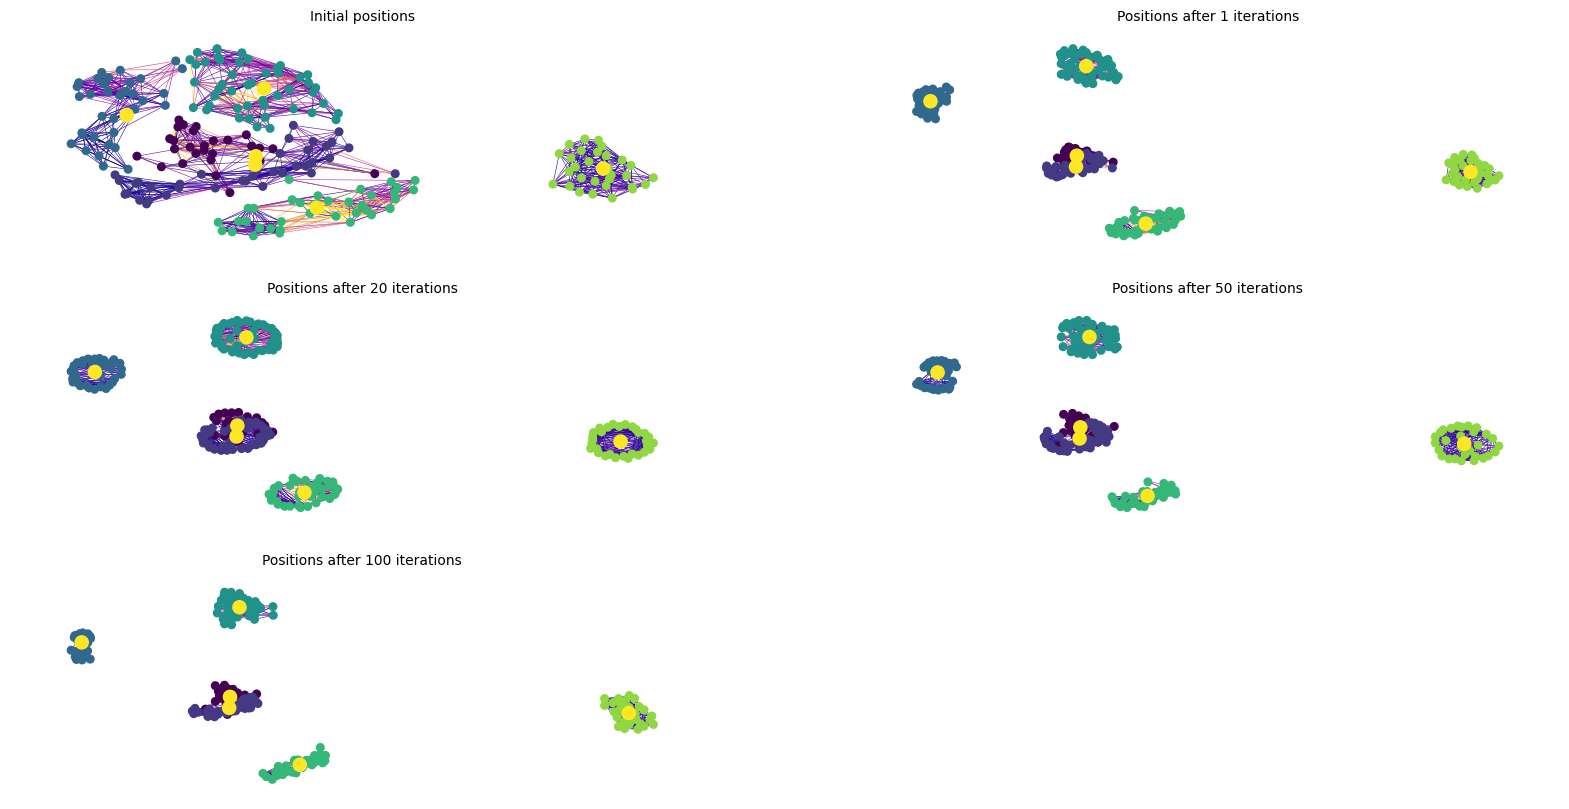

In [37]:
visualization.display_graphs(embeddings,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             # cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

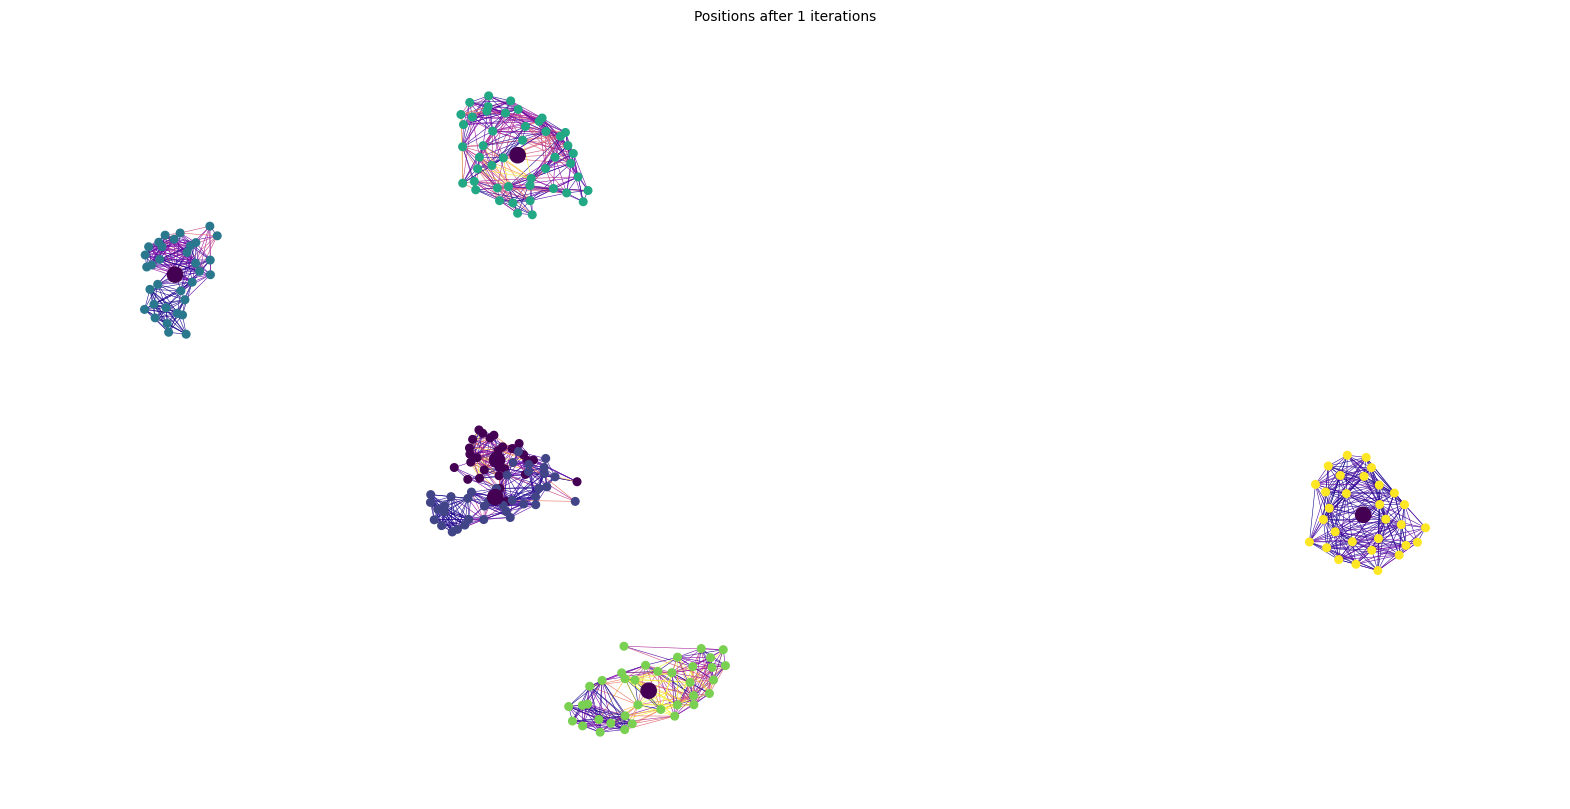

In [44]:
visualization.display_graphs([embeddings[1]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True
                             )

### 2.2 No MST, threshold at 0.1

In [45]:
embeddings_threshold, _ = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    [1, 20, 50, 100],
    threshold=0.1)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


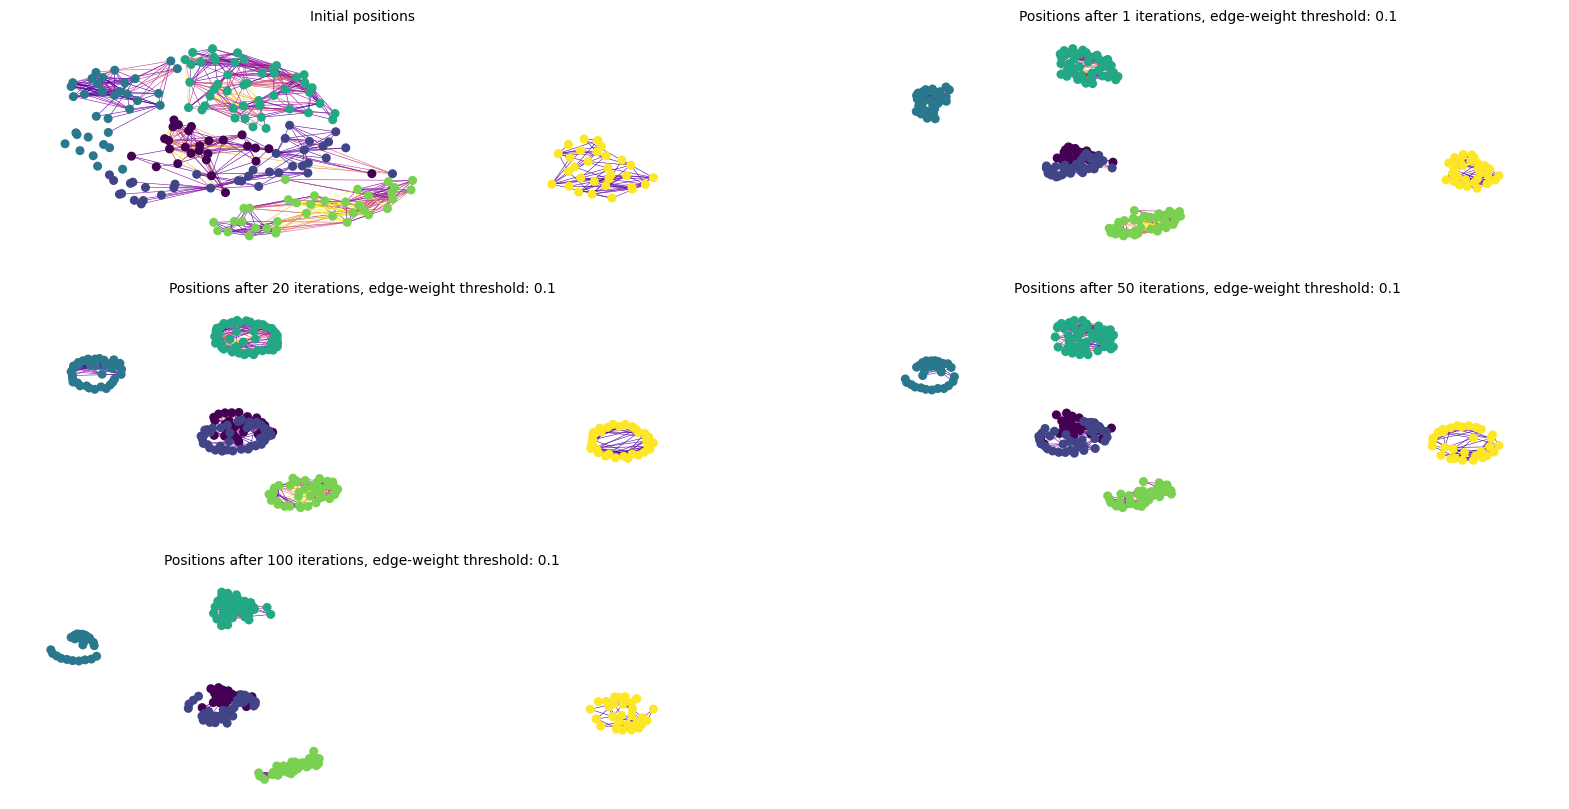

In [63]:
visualization.display_graphs(embeddings_threshold,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

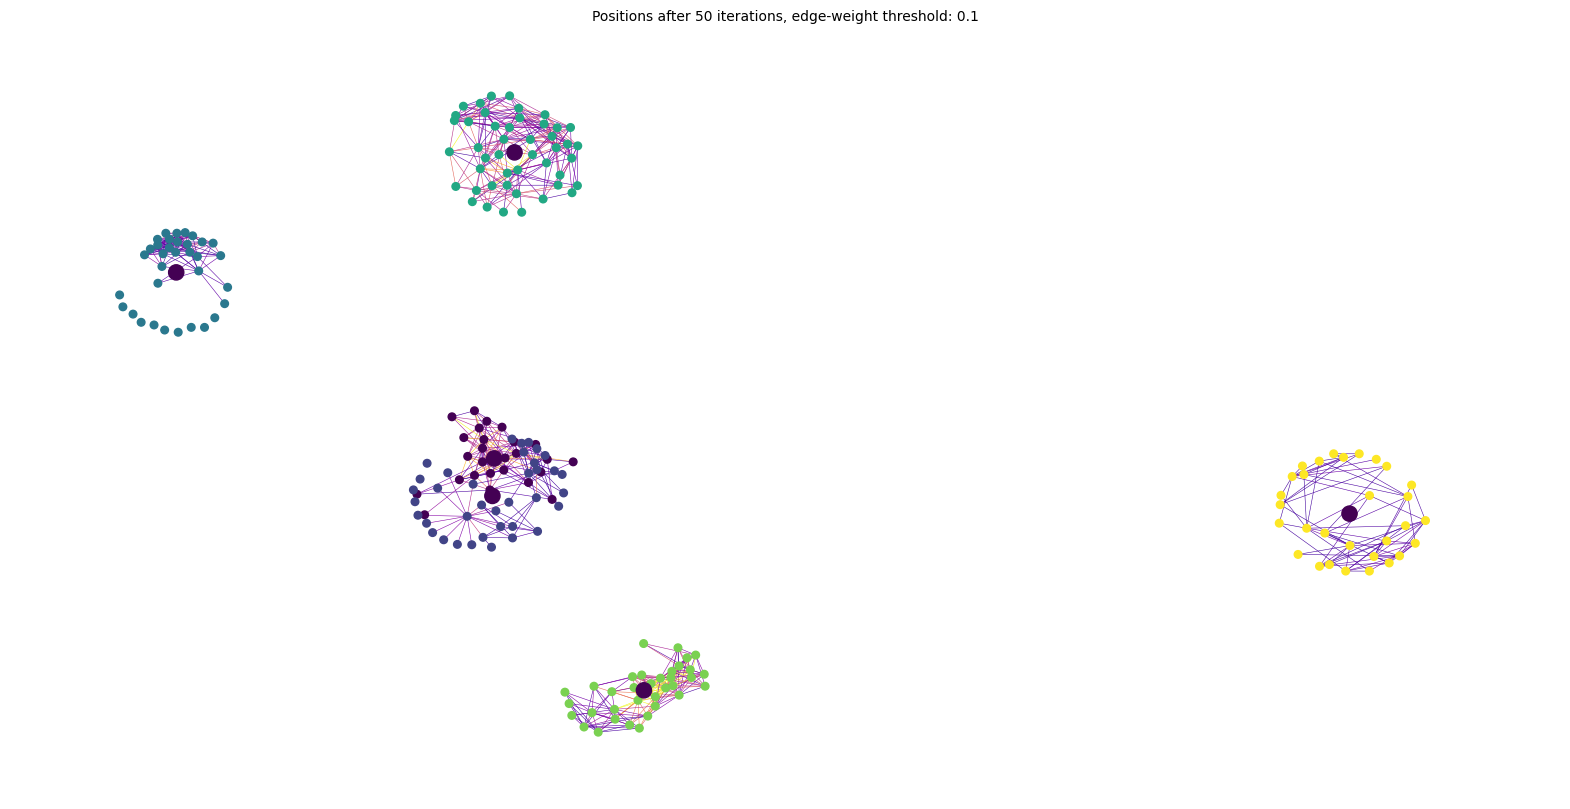

In [61]:
visualization.display_graphs([embeddings_threshold[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

### 2.3 MST, no threshold

In [48]:
embeddings_mst, _ = processing.compute_local_force_directed(connectivity_umap_knn_nx,
                                                            umap_embedding,
                                                            [1, 20, 50, 100], mst=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


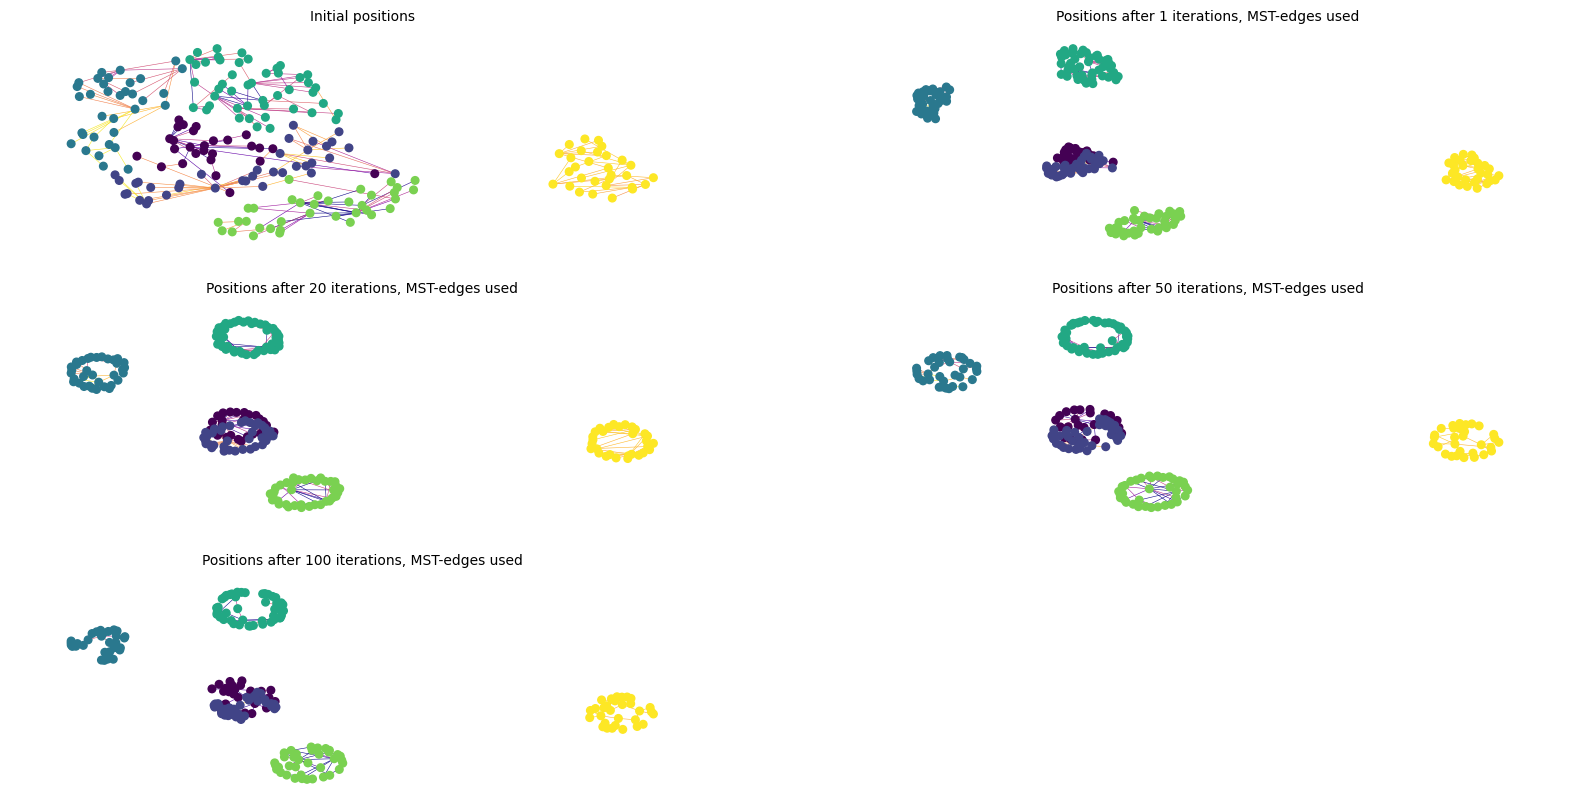

In [64]:
visualization.display_graphs(embeddings_mst,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

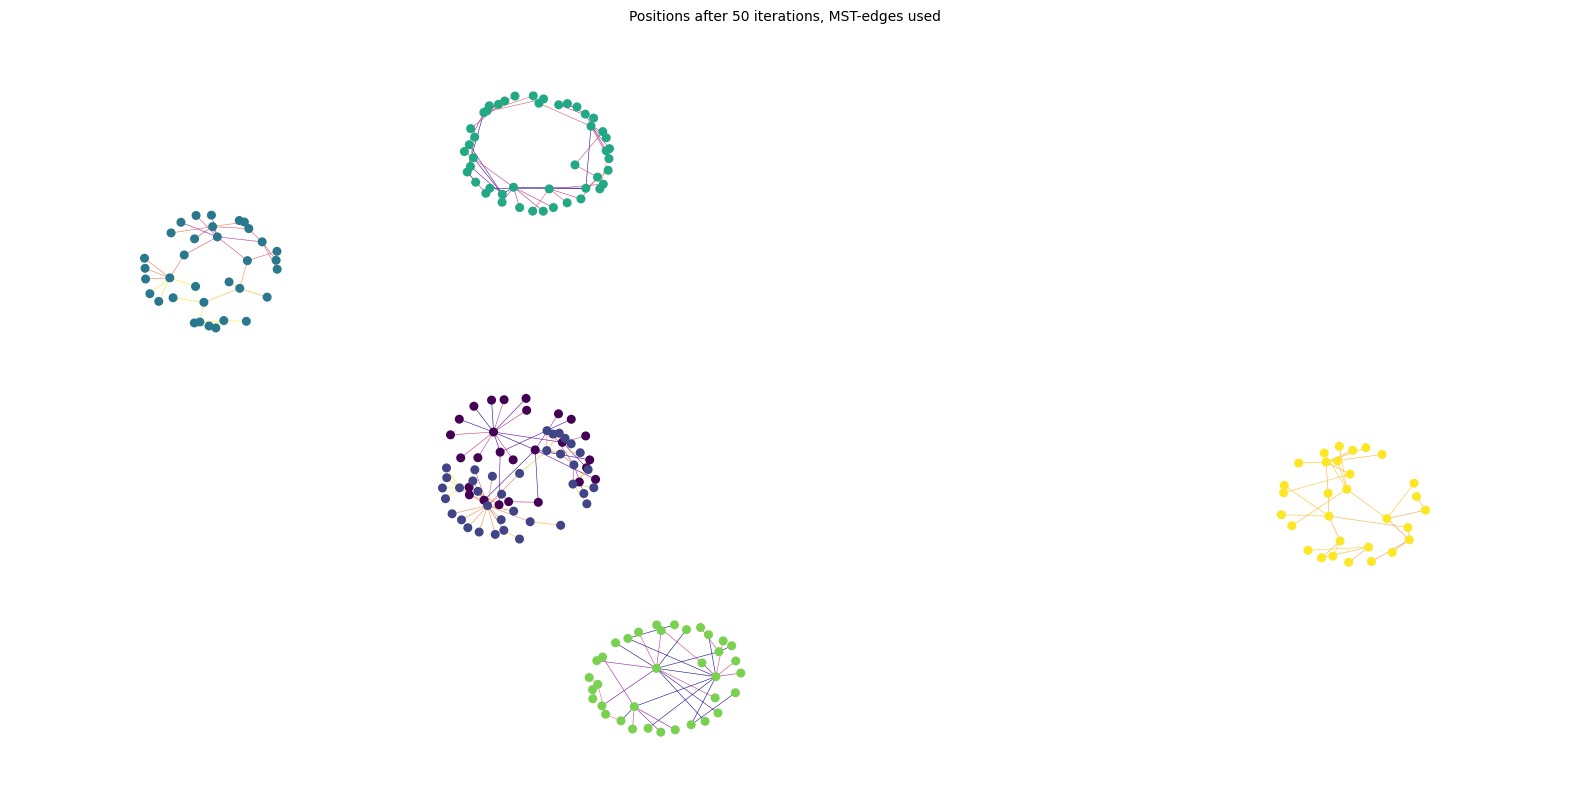

In [50]:
visualization.display_graphs([embeddings_mst[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

### 2.4 No MST, use boundary-edges

In [51]:
embeddings_boundaries, _ = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    [1, 20, 50, 100],
    boundary_edges=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


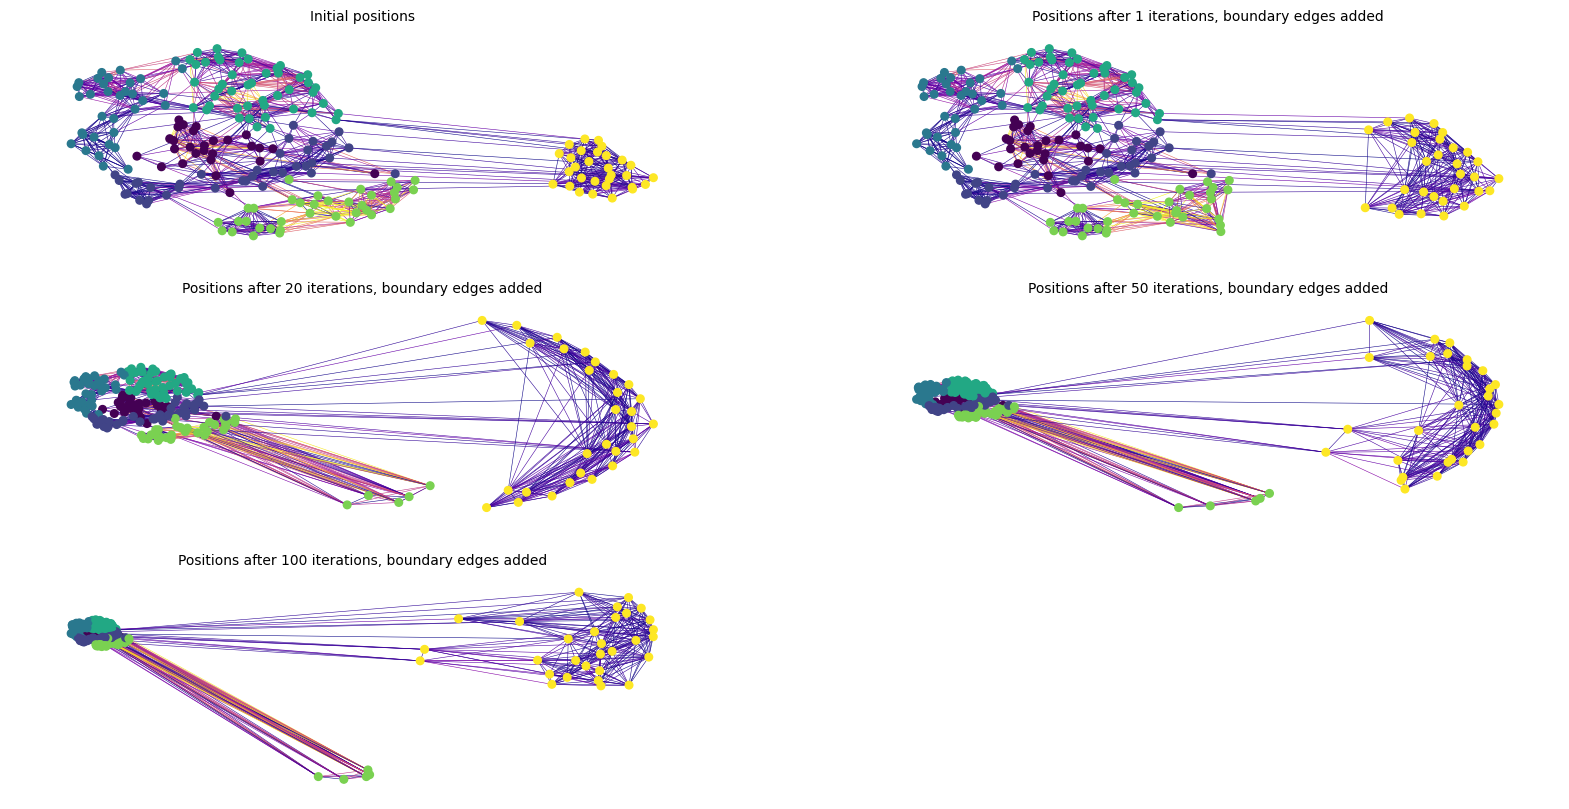

In [65]:
visualization.display_graphs(embeddings_boundaries,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

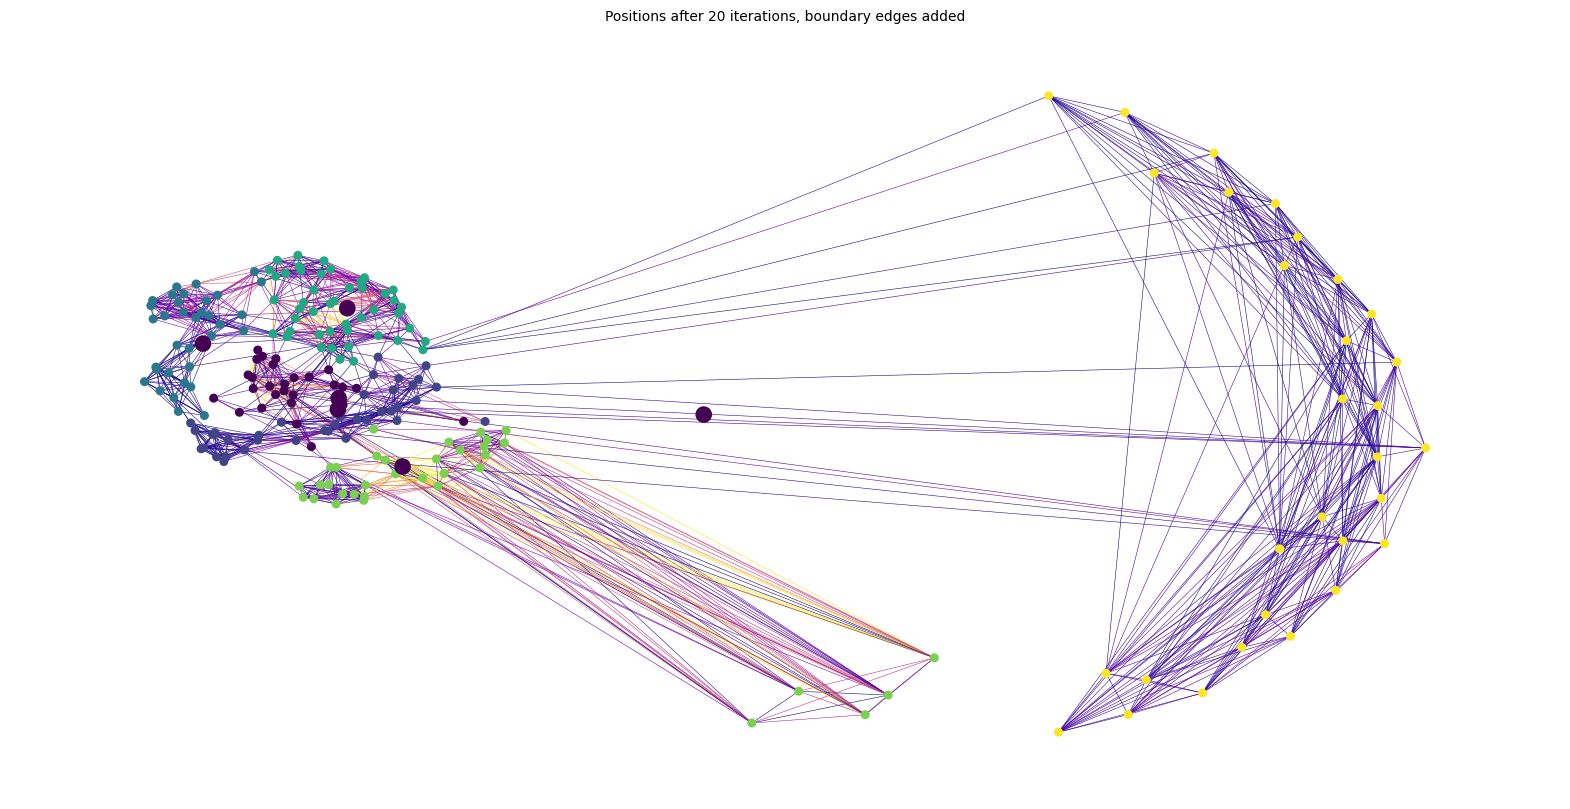

In [69]:
visualization.display_graphs([embeddings_boundaries[2]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

### 2.5 MST, use boundary-edges

In [54]:
embeddings_mst_boundaries, _ = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    [1, 20, 50, 100],
    mst=True,
    boundary_edges=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


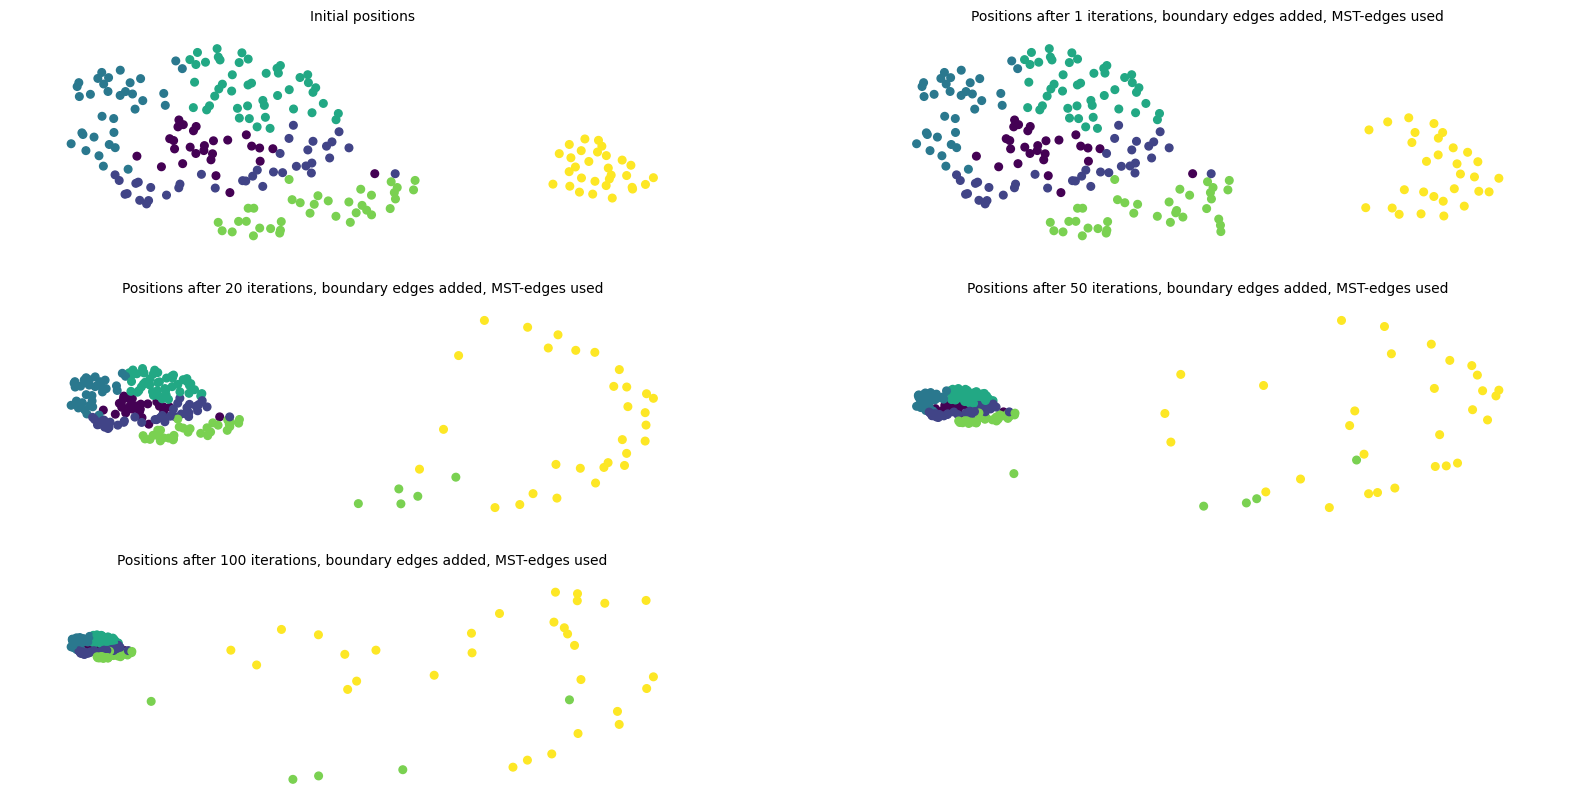

In [55]:
visualization.display_graphs(embeddings_mst_boundaries,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=False,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

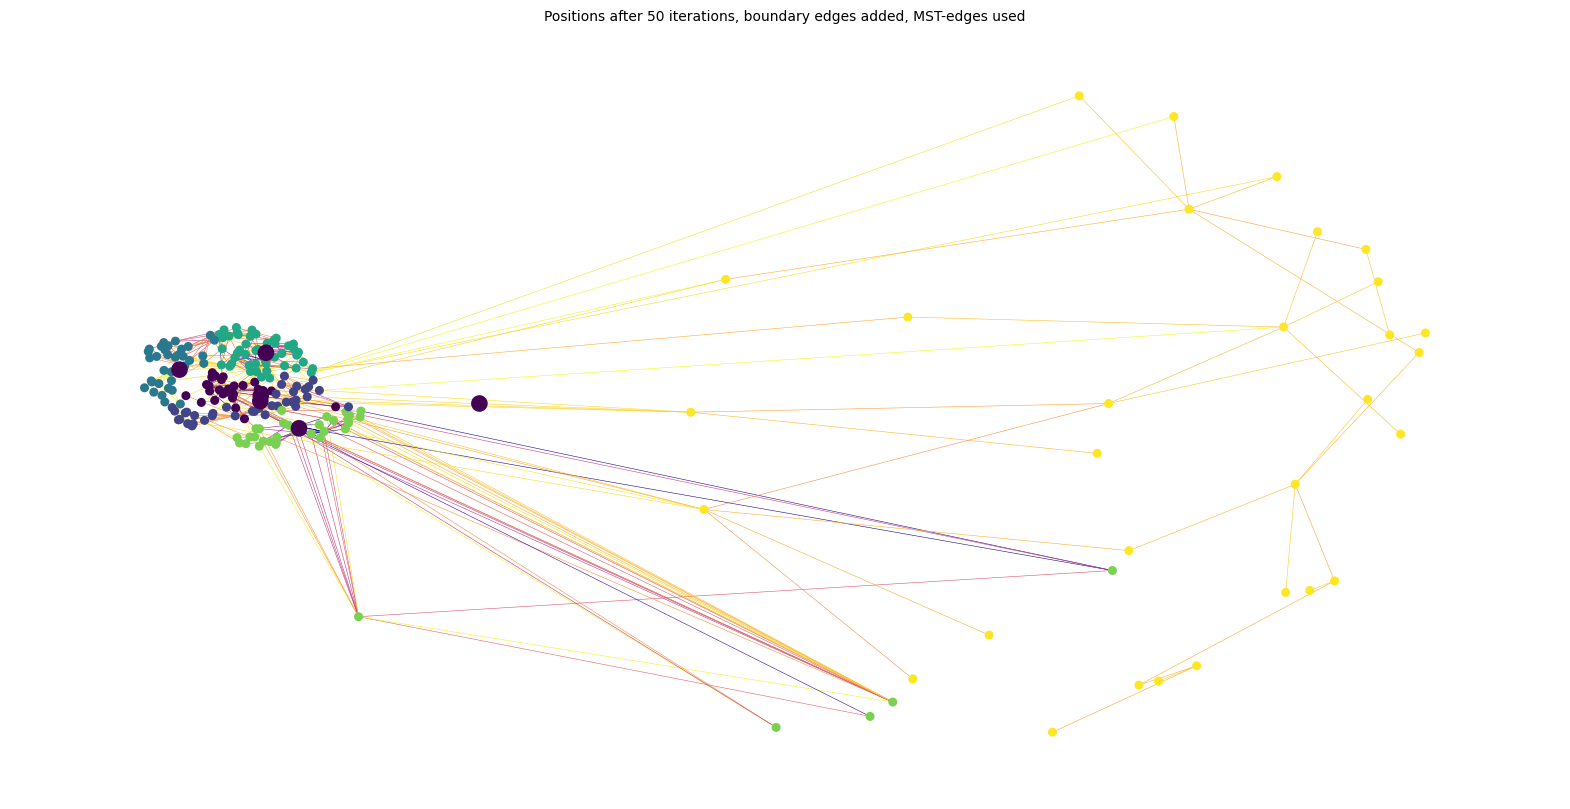

In [70]:
visualization.display_graphs([embeddings_mst_boundaries[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

### Error-Search: Missing Edges

In [57]:
original_edges = set(connectivity_umap_knn_nx.edges())
result_edges = set(embeddings[1].sim_graph.edges())
print("Missing edges:", len(original_edges - result_edges))

Missing edges: 309


In [58]:
missing_graph = nx.Graph(connectivity_umap_knn_nx)
missing_graph.clear_edges()

missing_edges = original_edges - result_edges
missing_graph.add_edges_from(missing_edges)

In [59]:
doppelte = []

for u, v in connectivity_umap_knn_nx.edges():
    if connectivity_umap_knn_nx.has_edge(v, u) and connectivity_umap_knn_nx.has_edge(u,
                                                                                     v):
        doppelte.append((u, v))

print(len(doppelte))

1825


D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


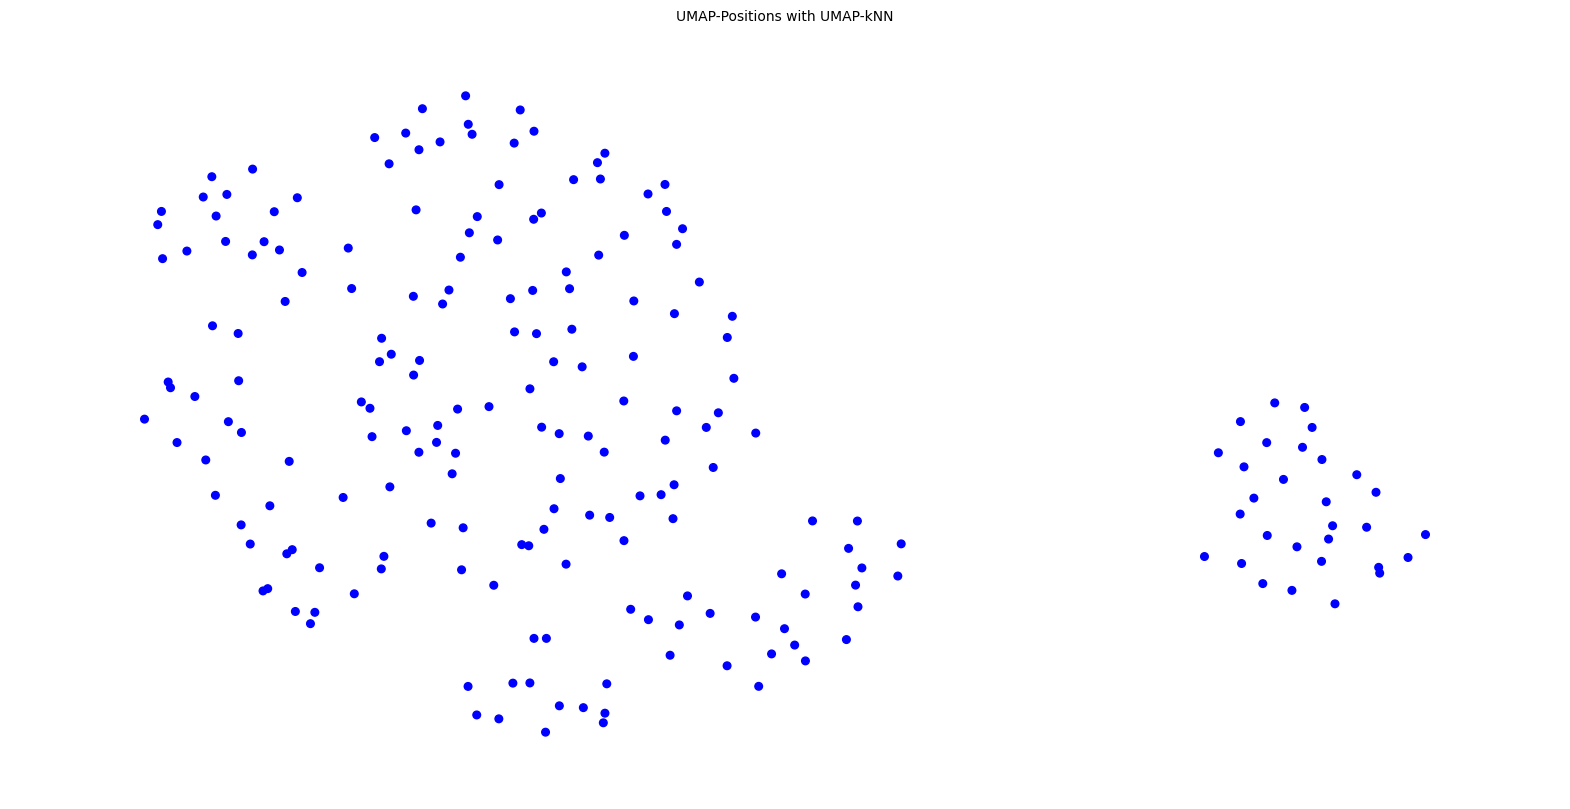

In [60]:
import numpy as np

visualization.display_graphs(
    [EmbeddingObj(graph=missing_graph, embedding=umap_embedding,
                  edge_weights=np.ndarray([0]),
                  title="UMAP-Positions with UMAP-kNN")],
    figsize_columns=1,
    figsize=(20, 10),
    show_edges=True,
    cmap='viridis',
    # cbar_labels=partition_values,
    show_cbar=False)